In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import os
from pathlib import Path
import sys

from customerSeg.config import data_dir

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_path = data_dir / 'raw' / 'Online_Retail_1.xlsx'

In [3]:
df = pd.read_excel(data_path, engine='openpyxl')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df = df[df['CustomerID'].notna()]

In [7]:
df_fix = df.sample(10000, random_state=18)

In [8]:
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date

df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]

df_fix.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
453504,575482,72122,COFFEE SCENT PILLAR CANDLE,4,2011-11-09,0.95,15916.0,United Kingdom,3.8
471878,576653,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,48,2011-11-16,2.55,14156.0,EIRE,122.4
312755,564372,21932,SCANDINAVIAN PAISLEY PICNIC BAG,10,2011-08-25,1.65,12714.0,France,16.5
438757,574328,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,4,2011-11-04,4.95,13081.0,United Kingdom,19.8
175851,551988,22673,FRENCH GARDEN SIGN BLUE METAL,12,2011-05-05,1.25,12576.0,Poland,15.0


In [9]:
snapshot_date = max(df_fix.InvoiceDate) + timedelta(days=1)

In [10]:
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)


In [11]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,40,2,44.10
12349.0,19,3,87.00
12350.0,311,1,19.80
12352.0,37,5,277.25
12354.0,233,3,33.25


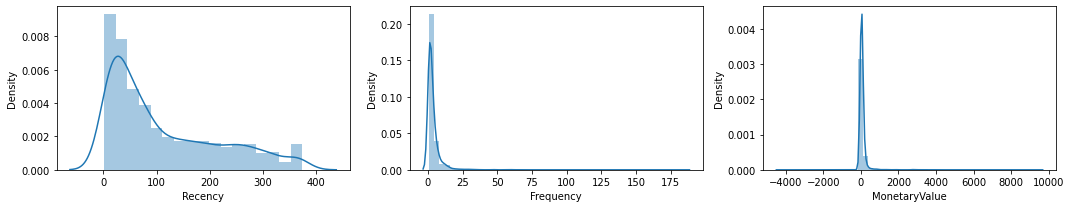

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(customers['Recency'], ax=ax[0])
sns.distplot(customers['Frequency'], ax=ax[1])
sns.distplot(customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()

In [13]:
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(customers[x], ax=ax[0,0])
    sns.distplot(np.log(customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
    print(customers[x].skew().round(2))
    print(np.log(customers[x]).skew().round(2))
    print(np.sqrt(customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(customers[x])[0]).skew().round(2))

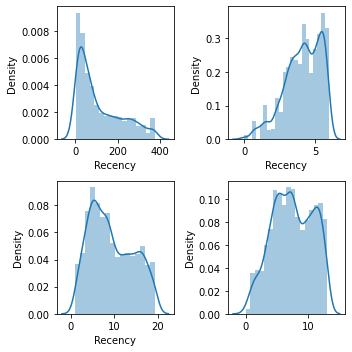

0.95
-0.67
0.36
-0.09


In [14]:
analyze_skewness('Recency')

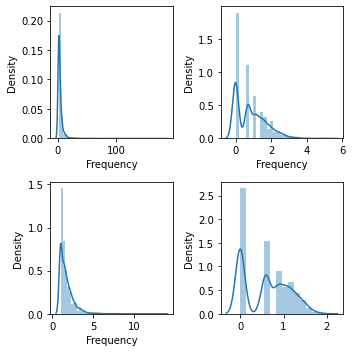

13.96
0.87
3.66
0.16


In [15]:
analyze_skewness('Frequency')

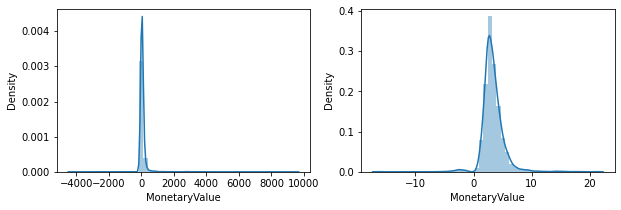

13.79
1.4


In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(customers['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(customers['MonetaryValue']), ax=ax[1])
plt.show()
print(customers['MonetaryValue'].skew().round(2))
print(np.cbrt(customers['MonetaryValue']).skew().round(2))

In [18]:
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values

In [19]:
customers_fix.head()

,Recency,Frequency,MonetaryValue
0,5.908990,0.590690,3.533021
1,4.266910,0.856151,4.431048
2,12.273913,0.000000,2.705339
3,5.723062,1.125490,6.520644
4,11.179275,0.856151,3.215614


In [20]:
scaler = StandardScaler()
scaler.fit(customers_fix)

StandardScaler()

In [21]:
customers_normalized = scaler.transform(customers_fix)

In [22]:
pd.DataFrame(customers_normalized).head()

,0,1,2
0,-0.485844,-0.011263,0.100590
1,-0.996041,0.500883,0.582342
2,1.491745,-1.150864,-0.343424
3,-0.543612,1.020510,1.703317
4,1.151640,0.500883,-0.069685


In [23]:
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0. -0.]
[1. 1. 1.]


In [24]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

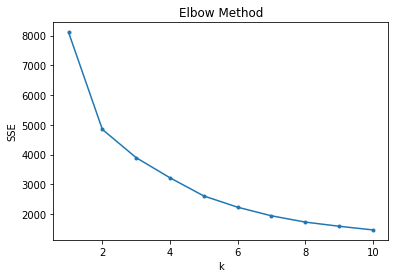

In [25]:
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(list(sse.keys()), list(sse.values()), marker='.')

In [26]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2704,)

In [27]:
customers.shape

(2704, 3)

In [28]:
customers['Cluster'] = model.labels_
customers.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347.0,40,2,44.10,2
12349.0,19,3,87.00,0
12350.0,311,1,19.80,1
12352.0,37,5,277.25,0
12354.0,233,3,33.25,1


In [29]:
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)


Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         47.52      7.43        185.01   975
1        227.78      1.62         29.51   970
2         43.85      1.56         14.56   759

In [30]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()


,ID,Cluster,Attribute,Value
0,12347.0,2,Recency,-0.485844
1,12349.0,0,Recency,-0.996041
2,12350.0,1,Recency,1.491745
3,12352.0,0,Recency,-0.543612
4,12354.0,1,Recency,1.151640


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

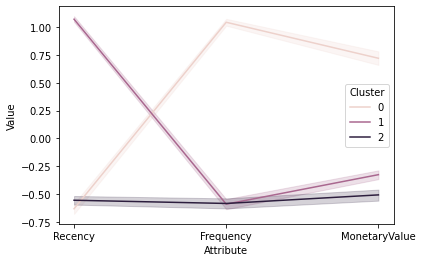

In [31]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

### Pyspark experimentation

TODO: Move to another notebook soon . . . 

In [32]:
# df.to_parquet('/Users/jared/DevProjects/customer-segmenter/data/Online Retail',
#              engine='fastparquet')

In [33]:
from pyspark import SparkContext, SQLContext
from pyspark.sql.types import StructType, StructField, StringType, DateType, IntegerType, FloatType

In [34]:
sc = SparkContext('local', '1_notebook')

In [35]:
sql_ctx = SQLContext(sc)

In [36]:
my_schema = StructType([
    StructField('InvoiceNo', StringType()),
    StructField('StockCode', StringType()),
    StructField('Description', StringType()),
    StructField('Quantity', IntegerType()),
    StructField('InvoiceDate', DateType()),
    StructField('UnitPrice', FloatType()),
    StructField('CustomerID', FloatType()),
    StructField('Country', StringType()),
])

In [37]:
sdf = sql_ctx.createDataFrame(df, schema=my_schema)

In [38]:
sdf.show(5)

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
only showing top 5 rows

